In [1]:
from __future__ import division
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import seaborn as sns
sns.set()
tau = 2 * pi
pylab.rcParams['figure.figsize'] = 12, 5

Populating the interactive namespace from numpy and matplotlib


# An Import Loop and a Fiery Reentry

Brandon Rhodes<br>
PyBay, San Francisco<br>
2018 August 18

In [2]:
from IPython.display import HTML

style = """
<style>
#header, div.unselected { display: none !important }
#notebook, .container { padding: 0 !important }
#site { height: 100% !important }
</style>
"""
style = ""

HTML(style)

1. The design of Skyfield
2. The art of the search
3. Tiangong-1 before dawn

In [3]:
from pytz import timezone
eastern = timezone('US/Eastern')
pacific = timezone('US/Pacific')

EDT = -4
PDT = -7

## The design of Skyfield

Pure Python

No object mutation

```
>>> my_list = [...]
>>> my_list.sort()
>>> print(my_list)
```
*vs*
```
>>> print(sorted(my_list))
```

In [4]:
import ephem
boston = ephem.Observer()
boston.lat = '42.37'
boston.lon = '-71.03'
mars = ephem.Mars()
altitudes = []
for hour in range(6):
    boston.date = '2018/8/18 %d' % hour  # awkward
    mars.compute(boston)                 # awkward
    altitudes.append(mars.alt)           # awkward
altitudes

[0.14778609573841095,
 0.26083600521087646,
 0.3371467590332031,
 0.3689298927783966,
 0.35250324010849,
 0.2898140251636505]

In [5]:
from skyfield.api import load, Topos

ts = load.timescale()
t6 = ts.utc(2018, 8, 19, 6 - PDT)

planets = load('de421.bsp')
earth, sun = planets['earth'], planets['sun']
sf = earth + Topos('37.7749 N', '122.4194 W')
alt, az, distance = sf.at(t6).observe(sun).apparent().altaz()
print(alt)

-06deg 12' 11.4"


Separate positions from coordinates

*Symptom: “PyEphem’s results don’t match…”*

*two axes: which position? which coordinates?*

```
astrometric.radec(J2000)
astrometric.radec('date')
astrometric.ecliptic_latlon()

apparent = astrometric.apparent()

apparent.radec(J2000)
apparent.radec('date')
apparent.ecliptic_latlon()
```

Explicit units

NumPy Arrays

Method chaining

```
apparent = astrometric.apparent()
geocentric = boston.at(t)
```

```
topos = geocentric.subpoint()
```

```
Traceback (most recent call last):
  ...
  File "/home/brandon/src/skyfield/skyfield/toposlib.py",
  line 7, in <module>
    from .vectorlib import VectorFunction
ImportError: cannot import name 'VectorFunction'
```

*flaw in Python's design*

http://rhodesmill.org/skyfield/

## The art of the search

1. Create a number
2. Draw a picture
3. Launch a search

In [6]:
def f(hour):
    t = ts.utc(2018, 8, 19, array(hour) - PDT)
    alt, az, distance = sf.at(t).observe(sun).apparent().altaz()
    return alt.degrees

f(6)

-6.2031746264292069

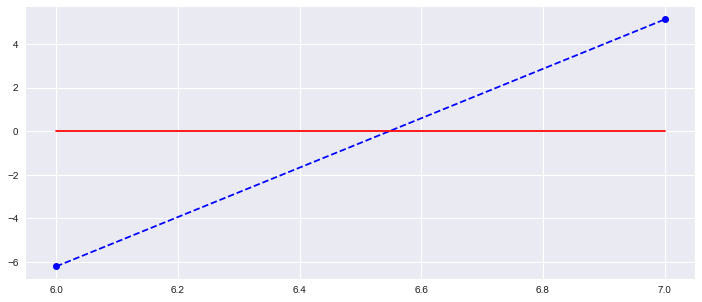

In [7]:
plot([6, 7], [f(6), f(7)], 'bo--')
plot([6, 7], [0, 0], 'r-')

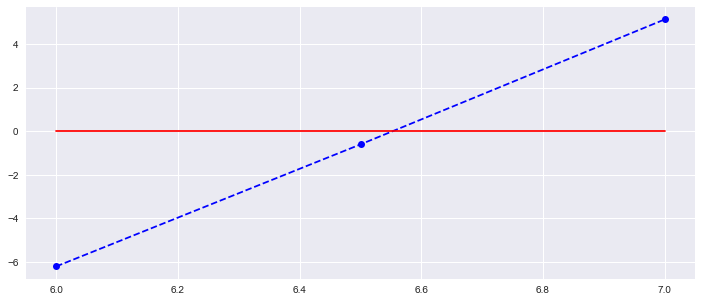

In [8]:
h = [6, 6.5, 7]
plot(h, f(h), 'bo--')
plot(h, zeros(len(h)), 'r-')

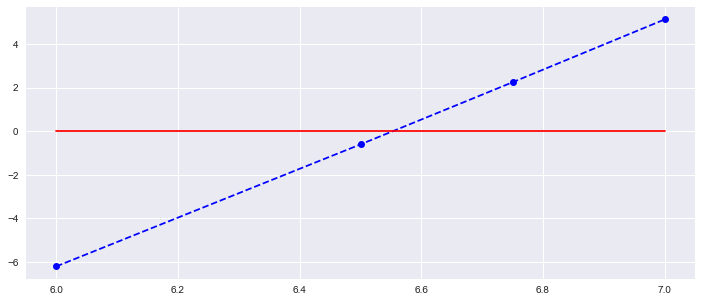

In [9]:
h = [6, 6.5, 6.75, 7]
plot(h, f(h), 'bo--')
plot(h, zeros(len(h)), 'r-')

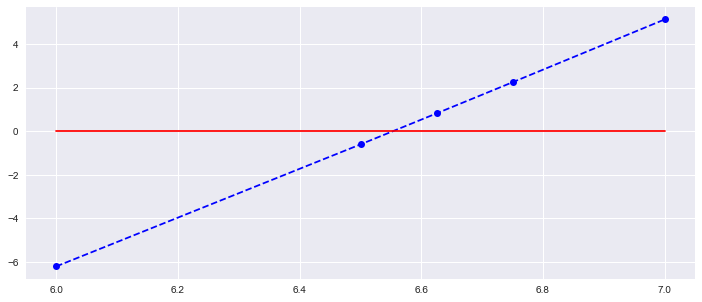

In [10]:
h = [6, 6.5, 6.625, 6.75, 7]
plot(h, f(h), 'bo--')
plot(h, zeros(len(h)), 'r-')

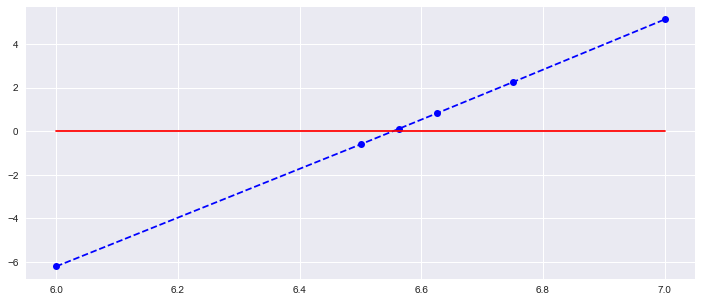

In [11]:
h = [6, 6.5, 6.5625, 6.625, 6.75, 7]
plot(h, f(h), 'bo--')
plot(h, zeros(len(h)), 'r-')

In [12]:
interval_start = 7 - 6
interval_end = 1/3600
print(log(interval_start / interval_end) / log(2))

11.8137811912


In [13]:
h0 = 6
h1 = 7
while h1 - h0 > 1/3600:
    h = (h1 + h0) / 2
    print(h, h1 - h0)
    if f(h) > 0:
        h1 = h
    else:
        h0 = h

6.5 1
6.75 0.5
6.625 0.25
6.5625 0.125
6.53125 0.0625
6.546875 0.03125
6.5546875 0.015625
6.55078125 0.0078125
6.552734375 0.00390625
6.5537109375 0.001953125
6.55322265625 0.0009765625
6.552978515625 0.00048828125


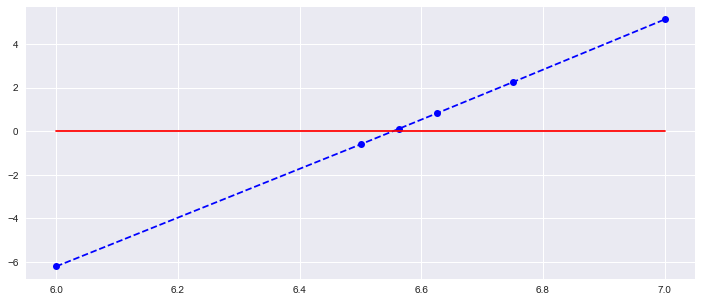

In [14]:
h = [6, 6.5, 6.5625, 6.625, 6.75, 7]
plot(h, f(h), 'bo--')
plot(h, zeros(len(h)), 'r-')

In [15]:
# What if we guess the answer is at the intercept
# of our current two guesses with the f() == 0 line?
# "Secant Method"

h0 = 6
h1 = 7
while abs(h1 - h0) > 1/3600:
    h = (h0 * f(h1) - h1 * f(h0)) / (f(h1) - f(h0))
    h0, h1 = h1, h
    print(h0, h1, h1 - h0)

7 6.54694463859 -0.453055361411
6.54694463859 6.5528044219 0.00585978330672
6.5528044219 6.55285986302 5.54411210123e-05


*finesse*

In [16]:
h0 = 13
h1 = 14
while abs(h1 - h0) > 1/3600:
    h = (h0 * f(h1) - h1 * f(h0)) / (f(h1) - f(h0))
    h0, h1 = h1, h
    print(h0, h1, h1 - h0)

14 46.7330269248 32.7330269248
46.7330269248 36.3522877544 -10.3807391704
36.3522877544 43.414275601 7.06198784665
43.414275601 44.0471466827 0.632871081615
44.0471466827 43.8577868537 -0.189359828971
43.8577868537 43.8560188689 -0.00176798479261
43.8560188689 43.8560266582 7.789339449e-06


In [17]:
def draw_arrow(x0, y0, x1, y1):
    annotate(
        '', (x1, y1), (x0, y0),
        xycoords='data',
        arrowprops={
            'arrowstyle':'->, head_width=0.5, head_length=1',
                    'linewidth': 1,
                    'color':'k'},
    )

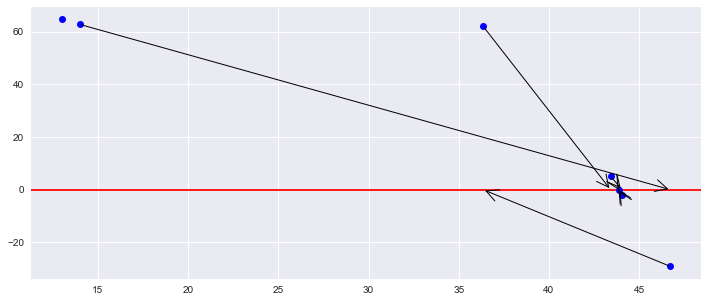

In [18]:
fig, ax = plt.subplots()
h0 = 13
h1 = 14
axhline(0, color='r')
while abs(h1 - h0) > 1/3600:
    h = (h0 * f(h1) - h1 * f(h0)) / (f(h1) - f(h0))
    plot(h0, f(h0), 'bo')
    draw_arrow(h1, f(h1), h, 0)
    h0, h1 = h1, h

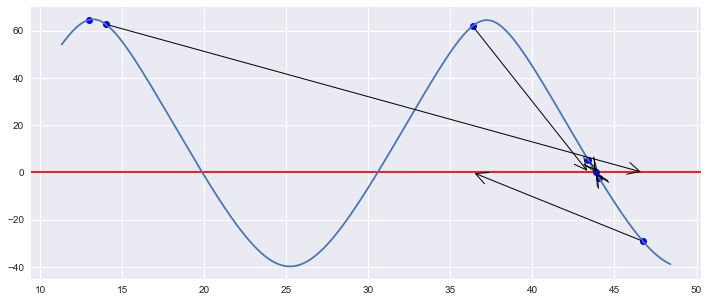

In [19]:
# The secant method can only "see"
# tiny fragments of the whole curve.

t = arange(*ax.get_xlim(), 0.1)
ax.plot(t, f(t))
fig

secant method is
difficult to control

*but*

efficient

does safety have to be expensive?

In [20]:
%timeit f(6)
%timeit f([6])
%timeit f([6, 7, 8, 9])

6.78 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.54 ms ± 51.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.81 ms ± 45.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
h0 = 6
h1 = 7
h = linspace(h0, h1, 5)
h

array([ 6.  ,  6.25,  6.5 ,  6.75,  7.  ])

In [22]:
f(h)

array([-6.20317463, -3.42192169, -0.60100898,  2.25410573,  5.13832904])

In [23]:
f(h) > 0

array([False, False, False,  True,  True], dtype=bool)

In [24]:
argmax(f(h) > 0)

3

In [25]:
h0, h1 = 6, 7
while h1 - h0 > 1/3600:
    h = linspace(h0, h1, 5)
    print(h)
    i = argmax(f(h) > 0)
    h0, h1 = h[i-1], h[i]

[ 6.    6.25  6.5   6.75  7.  ]
[ 6.5     6.5625  6.625   6.6875  6.75  ]
[ 6.5       6.515625  6.53125   6.546875  6.5625  ]
[ 6.546875    6.55078125  6.5546875   6.55859375  6.5625    ]
[ 6.55078125  6.55175781  6.55273438  6.55371094  6.5546875 ]
[ 6.55273438  6.55297852  6.55322266  6.5534668   6.55371094]


In [26]:
def secant_search(h0, h1, epsilon, f):
    while abs(h1 - h0) > epsilon:
        f0, f1 = f(h0), f(h1)
        h = (h0 * f1 - h1 * f0) / (f1 - f0)
        h0, h1 = h1, h
    return h

In [27]:
def phalanx_search(h0, h1, epsilon, length, f):
    while h1 - h0 > epsilon:
        h = linspace(h0, h1, length)
        i = argmax(f(h) > 0)
        h0, h1 = h[i-1], h[i]
    return h0

In [28]:
%timeit secant_search(6, 7, 1/3600, f)
%timeit phalanx_search(6, 7, 1/3600, 4, f)
%timeit phalanx_search(6, 7, 1/3600, 8, f)
%timeit phalanx_search(6, 7, 1/3600, 16, f)

39.5 ms ± 255 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
70.7 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
50 ms ± 450 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
49.2 ms ± 480 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
def secant_search(h0, h1, epsilon, f):
    while abs(h1 - h0) > epsilon:
        f0, f1 = f(h0), f(h1)
        h = (h0 * f1 - h1 * f0) / (f1 - f0)
        h0, h1 = h1, h
    return h

In [30]:
def secant_search2(h0, h1, epsilon, f):
    while abs(h1 - h0) > epsilon:
        f0, f1 = f([h0, h1])
        h = (h0 * f1 - h1 * f0) / (f1 - f0)
        h0, h1 = h1, h
    return h

In [31]:
from scipy.optimize import brentq

In [32]:
print(brentq(f, 6, 7, xtol=1/3600))
print(secant_search(6, 7, 1/3600, f))
print(secant_search2(6, 7, 1/3600, f))
print(phalanx_search(6, 7, 1/3600, 3, f))
print(phalanx_search(6, 7, 1/3600, 5, f))
print(phalanx_search(6, 7, 1/3600, 9, f))

6.552804421896084
6.55285986302
6.55285986302
6.552734375
6.552734375
6.552734375


In [33]:
%timeit brentq(f, 6, 7, xtol=1/3600)
%timeit secant_search(6, 7, 1/3600, f)
%timeit secant_search2(6, 7, 1/3600, f)
%timeit phalanx_search(6, 7, 1/3600, 4, f)
%timeit phalanx_search(6, 7, 1/3600, 8, f)
%timeit phalanx_search(6, 7, 1/3600, 16, f)

32.7 ms ± 186 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
39.3 ms ± 447 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
24.4 ms ± 411 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
70.4 ms ± 485 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
49.9 ms ± 511 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
48.9 ms ± 470 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


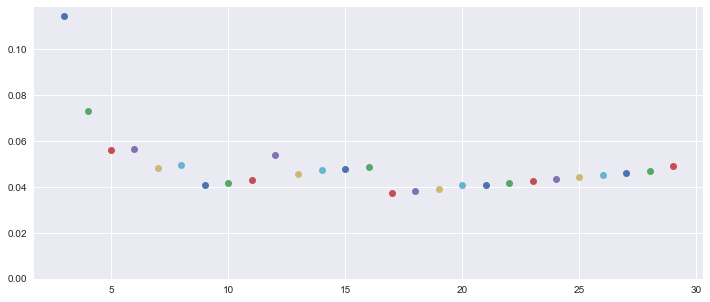

In [34]:
from time import time
for i in range(3, 30):
    t0 = time()
    phalanx_search(6, 7, 1/3600, i, f)
    dt = time() - t0
    plot(i, dt, 'o')
ylim(0);

Have we found sunrise?

In [35]:
h0 // 1, h0 * 60 // 1 % 60, h0 * 3600 // 1 % 60

(6.0, 33.0, 9.0)

<img src="sunrise-form.png">

<table class="tableA">
            <tr class="trA"><td class="tdAleft">Sunday, August 19, 2018</td>
            <td class="tdAright">Pacific Daylight Time</td></tr></table><table>
          <tr style="font-size:20px">
          <th colspan="2">Sun</th>
          </tr>
            <tr><td>Begin civil twilight</td><td>6:01 a.m.</td></tr>
            <tr><td>Sunrise</td><td>6:29 a.m.</td></tr>
            <tr><td>Sun transit</td><td>1:13 p.m.</td></tr>
            <tr><td>Sunset</td><td>7:57 p.m.</td></tr>
            <tr><td>End civil twilight</td><td>8:25 p.m.</td></tr><tr style="font-size:20px"><th colspan="2">Moon</th></tr>
               <tr><td>Moonset</td><td>12:50 a.m.</td></tr>
               <tr><td>Moonrise</td><td>3:15 p.m.</td></tr>
               <tr><td>Moon transit</td><td>8:24 p.m.</td></tr>
         <tr><td>Moonset</td><td>1:30 a.m. on following day</td></tr></table>

“For computational purposes, sunrise or sunset is defined to occur when the geometric zenith distance of center of the Sun is 90.8333 degrees.”

http://aa.usno.navy.mil/faq/docs/RST_defs.php

In [36]:
def phalanx_search(t0, t1, epsilon, f):
    jd0, jd1 = t0.tt, t1.tt
    while jd1 - jd0 > epsilon:       # Julian Dates
        jd = linspace(jd0, jd1, 16)
        t = ts.tt(jd=jd)
        i = argmax(f(t) > 0)         # search still looks for zero
        jd0, jd1 = jd[i-1], jd[i]
    return ts.tt(jd=jd0)

def sunrise(topos):
    def sunrise_altitude(t):
        alt, az, distance = topos.at(t).observe(sun).apparent().altaz()
        return alt.degrees + 0.8333  # it's f() that I've adjusted
    return sunrise_altitude

In [37]:
t = phalanx_search(
    ts.utc(2018, 8, 19, 6 - PDT),
    ts.utc(2018, 8, 19, 7 - PDT),
    1e-8,
    sunrise(sf),
)

t.astimezone(pacific).isoformat(' ')

'2018-08-19 06:28:46.321000-07:00'

<table class="tableA">
          <tr style="font-size:20px">
          <th colspan="2">Sun</th>
          </tr>
            <tr><td>Sunrise</td><td>6:29 a.m.</td></tr>
</table>

In [38]:
# What if we want the sun's maximum altitude?

for h in 10, 11, 12, 13, 14:
    t = ts.utc(2018, 8, 19, h - PDT)
    alt, az, distance = sf.at(t).observe(sun).apparent().altaz()
    print(h, alt)

10 40deg 18' 01.9"
11 51deg 06' 27.2"
12 59deg 59' 17.4"
13 64deg 38' 06.4"
14 62deg 43' 08.5"


In [39]:
t = ts.utc(2018, 8, 19, [h - PDT for h in range(10, 15)])
alt, az, distance = sf.at(t).observe(sun).apparent().altaz()
d = alt.degrees
print(d)

[ 40.30053222  51.10755183  59.98815534  64.63510376  62.71902597]


In [40]:
print(d)
i = argmax(d)
print(i)
print(d[i-1], d[i], d[i+1])

[ 40.30053222  51.10755183  59.98815534  64.63510376  62.71902597]
3
59.988155341 64.6351037607 62.7190259683


In [41]:
def sunalt(t):
    alt, az, distance = sf.at(t).observe(sun).apparent().altaz()
    return alt.degrees

In [42]:
def maximize(t0, t1, epsilon, f):
    jd0, jd1 = t0.tt, t1.tt
    while jd1 - jd0 > epsilon:
        jd = linspace(jd0, jd1, 16)
        t = ts.tt(jd=jd)
        i = argmax(f(t))
        i = clip(i, 1, 14)
        jd0, jd1 = jd[i-1], jd[i+1]
    return ts.tt(jd=jd0)

2018-08-19 13:13:07.075000-07:00


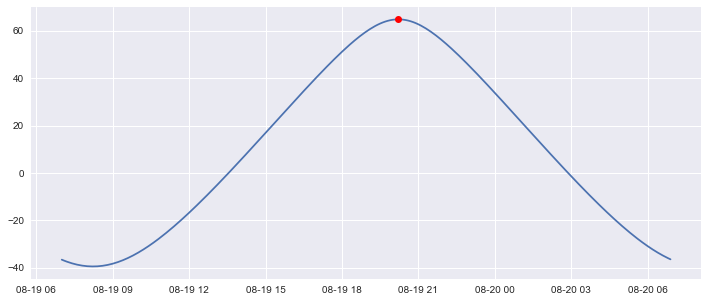

In [43]:
t = maximize(ts.utc(2018, 8, 19, 10 - PDT),
             ts.utc(2018, 8, 19, 14 - PDT), 1e-8, sunalt)
print(t.astimezone(pacific))

day = ts.utc(2018, 8, 19, arange(-PDT, 24-PDT, 0.1))
plot(day.utc_datetime(), sunalt(day))
plot(t.utc_datetime(), sunalt(t), 'ro')

## Tiangong-1 before dawn

<img width="100%" src="/files/Talks/debris.jpg">

<img src="tiangong-1-headline.png">

In [44]:
satellites = load.tle('stations-2018-03-31.tle')
sats = set(sat for sat in satellites.values())
tg = satellites['TIANGONG 1']
tg

<EarthSatellite 'TIANGONG 1' number=37820 epoch=2018-03-31T15:17:46Z>

In [45]:
# When was sunrise?

bluffton = Topos('40.8953 N', '83.8888 W')
EST = -4
t = phalanx_search(
    ts.utc(2018, 8, 19, 4 - EDT),
    ts.utc(2018, 8, 19, 10 - EDT),
    1e-8,
    sunrise(earth + bluffton),
)
t.astimezone(eastern).isoformat(' ')

'2018-08-19 06:49:32.594000-04:00'

In [46]:
# How high will Tiangong-1 pass overhead?
# I knew better than to do this:

t0, t1 = ts.utc(2018, 4, 1, [3-EDT, 7-EDT])
f = lambda t: (tg - bluffton).at(t).altaz()[0].degrees
tm = maximize(t0, t1, 1/24/3600, f)
print(tm.astimezone(eastern))
print(f(tm))

2018-04-01 05:04:19.442000-04:00
8.02818694509


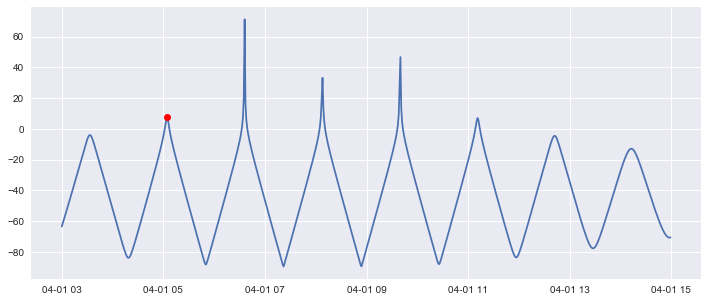

In [47]:
t = ts.utc(2018, 4, 1, arange(0-PDT, 12-PDT, 1/60))
alt, az, distance = (tg - bluffton).at(t).altaz()
plot(t.astimezone(eastern), alt.degrees)
plot(tm.astimezone(eastern), f(tm), 'ro')

In [48]:
print(alt)
above_horizon = alt.degrees > 0
print(above_horizon[300:320])

720 values from -89deg 22' 48.4" to 71deg 09' 35.4"
[False False False False False  True  True  True  True  True  True  True
 False False False False False False False False]


In [49]:
boundaries, = diff(above_horizon).nonzero()
print(boundaries)

passes = boundaries.reshape(len(boundaries) // 2, 2)
print(passes)

[121 127 212 219 304 311 396 402 488 493]
[[121 127]
 [212 219]
 [304 311]
 [396 402]
 [488 493]]


In [50]:
for i, j in passes:
    tm = maximize(t[i], t[j], 1/24/3600, f)
    dt = tm.astimezone(eastern).replace(microsecond=0)
    print(i, j, '-', dt, ' max:', f(tm))

121 127 - 2018-04-01 05:04:19-04:00  max: 8.02815684284
212 219 - 2018-04-01 06:35:53-04:00  max: 78.6388836924
304 311 - 2018-04-01 08:07:47-04:00  max: 35.0448055564
396 402 - 2018-04-01 09:39:40-04:00  max: 69.3280604105
488 493 - 2018-04-01 11:11:11-04:00  max: 7.13484449196


In [51]:
def plot_sky(pass_indices):
    i, j = pass_indices
    
    # Set up the polar plot.
    ax = plt.subplot(111, projection='polar')
    ax.set_rlim([0, 90])
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    
    # Draw line and labels.
    θ = az.radians
    r = 90 - alt.degrees
    ax.plot(θ[i:j], r[i:j], 'ro--')
    for k in range(i, j):
        if r[k] < 90:
            text = t[k].astimezone(eastern).strftime('%H:%M')
            ax.text(θ[k], r[k], text, ha='right', va='bottom')

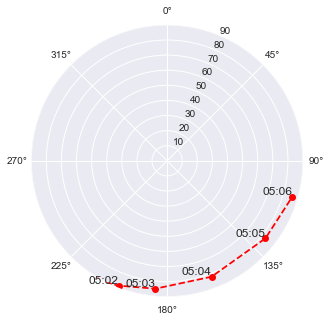

In [52]:
plot_sky(passes[0])

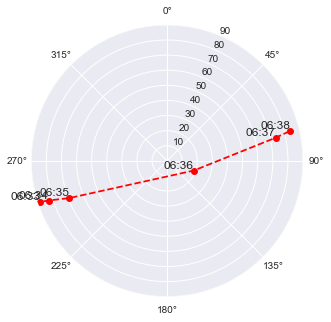

In [53]:
plot_sky(passes[1])

In [54]:
ranking = []
for sat in sats:
    position = sat.at(t)
    v = position.velocity.km_per_s
    speed = sqrt((v * v).sum(axis=0))
    if any(isnan(speed)):
        continue
    ranking.append((speed.max(), sat.name))
sorted(ranking, reverse=True)[:12]

[(7.8173700380390754, 'TIANGONG 1'),
 (7.7713895044393144, 'FLOCK 2E-3'),
 (7.7708767193198343, "FLOCK 2E'-6"),
 (7.7654272018910078, "FLOCK 2E'-8"),
 (7.7640859460472926, 'FLOCK 2E-7'),
 (7.7503277207092447, "FLOCK 2E'-1"),
 (7.7491267948326703, 'LEMUR-2-TRUTNA'),
 (7.7398574792890615, "FLOCK 2E'-3"),
 (7.7290743162519515, 'SGSAT'),
 (7.724553576349793, 'FLOCK 2E-1'),
 (7.7241591441473973, "FLOCK 2E'-19"),
 (7.718601467382185, "FLOCK 2E'-16")]

In [55]:
from skyfield.constants import ERAD
ranking = []
for sat in sats:
    position = sat.at(t)
    p = position.position.km
    elevation = sqrt((p * p).sum(axis=0)) - ERAD / 1e3
    if isnan(elevation.min()):
        continue
    ranking.append((elevation.min(), sat.name))
sorted(ranking)[:12]

[(152.637994664703, 'TIANGONG 1'),
 (228.19857112640602, 'FLOCK 2E-3'),
 (229.89422615395324, "FLOCK 2E'-6"),
 (236.54504392228773, "FLOCK 2E'-8"),
 (241.50460836659931, 'FLOCK 2E-7'),
 (263.94458563135959, "FLOCK 2E'-1"),
 (264.68434345582318, 'LEMUR-2-TRUTNA'),
 (281.12965303895089, "FLOCK 2E'-3"),
 (299.76594675735396, 'SGSAT'),
 (307.00412177630278, 'FLOCK 2E-1'),
 (308.6281808527001, "FLOCK 2E'-19"),
 (315.88312026581843, "FLOCK 2E'-16")]

In [56]:
speeds = []
for sat in sats:
    position = sat.at(t)
    p = position.position.km
    v = position.velocity.km_per_s
    speed = sqrt((v * v).sum(axis=0))
    elevation = sqrt((p * p).sum(axis=0)) - ERAD / 1e3
    if any(isnan(speed)):
        continue
    degrees_per_second = (speed / elevation) / tau * 360
    speeds.append((degrees_per_second.max(), sat.name))
sorted(speeds, reverse=True)[:12]

[(2.9338411219707807, 'TIANGONG 1'),
 (1.950226352798593, 'FLOCK 2E-3'),
 (1.935700056244787, "FLOCK 2E'-6"),
 (1.8801163067023796, "FLOCK 2E'-8"),
 (1.8410053914939264, 'FLOCK 2E-7'),
 (1.6818227003247974, "FLOCK 2E'-1"),
 (1.6769832786583083, 'LEMUR-2-TRUTNA'),
 (1.5769751071946843, "FLOCK 2E'-3"),
 (1.4769760901020952, 'SGSAT'),
 (1.4413717163417743, 'FLOCK 2E-1'),
 (1.4335063861026922, "FLOCK 2E'-19"),
 (1.3997550431483754, "FLOCK 2E'-16")]

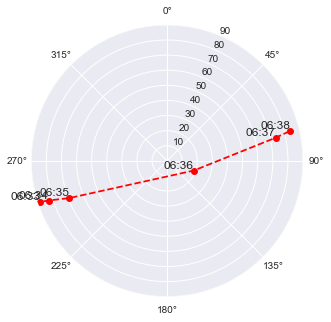

In [57]:
# Brandon Rhodes - @brandon_rhodes - PyBay 2018

plot_sky(passes[1])

In [58]:
from IPython.display import HTML
HTML("""
<style>
h1, h2, h3, .rendered_html p {
  text-align: center;
}
.anchor-link {
  display: none;  /* ruins centering of titles */
}
li, pre {
  text-align: left;
}
.text_cell_render.rendered_html {
  font-size: larger;
  text-align: center;
}
</style>
<script src="slide_timer.js"></script>
<script>
setup_timer();
</script>
""")